In [1]:
import os
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.mobile_optimizer import optimize_for_mobile
from farabio.models.classification import *
from farabio.data.biodatasets import ChestXrayDataset

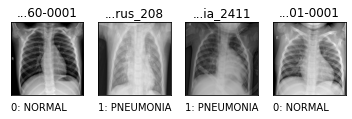

In [2]:
_path = "/home/data/07_SSD4TB/public-datasets/chest-xray"

train_dataset = ChestXrayDataset(root=_path, download=False, mode="train", show=True)
valid_dataset = ChestXrayDataset(root=_path, download=False, mode="val", show=False)

In [3]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8)

In [4]:
model = mobilenet_v3_small(n_classes=2)
device = "cuda:1"
model.to(torch.device(device))
print("model is ready!")

criterion = nn.CrossEntropyLoss()                   
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3)

def accuracy(preds, labels):
    preds = torch.exp(preds)
    top_p,top_class = preds.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

model is ready!


In [ ]:
epochs = 5
val_loss_min = np.Inf
model_name = 'pneumonia_final.pt'

for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0
    
    model.train()
    for images,labels,fnames in tqdm(train_loader):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy(preds, labels)

    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)

    model.eval()
    with torch.no_grad():
        for images,labels,fnames in tqdm(valid_loader):
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)
            loss = criterion(preds, labels)
            val_loss += loss.item()
            val_acc += accuracy(preds, labels)

        avg_val_loss = val_loss / len(valid_loader)
        avg_val_acc = val_acc / len(valid_loader)

    schedular.step(avg_val_loss)

    print("Epoch : {} \ntrain_loss : {:.6f}, \tTrain_acc : {:.6f}, \nVal_loss : {:.6f}, \tVal_acc : {:.6f}".format(epoch + 1,
                                                                                                                   avg_train_loss, avg_train_acc,
                                                                                                                   avg_val_loss, avg_val_acc))

    if avg_val_loss <= val_loss_min:
        print('Validation loss decreased from ({:.6f} --> {:.6f}).\nSaving model ...'.format(val_loss_min, avg_val_loss))
        torch.save(model.state_dict(), model_name)
        val_loss_min = avg_val_loss
        
print("training finished!")

 12%|████▉                                     | 38/326 [00:09<01:16,  3.77it/s]